I. Import Packages

In [1]:
#Importing functions library

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

II. Creating Separate Functions for Airline Delay Prediction

In [2]:
# DONT REALLY UNDERSTAND THE CODE FOR THIS PART VERY WELL 
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [3]:
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [4]:
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

III. Data Wraggling for Flights Dataset

In [5]:
#Importing Flight dataset as flights_df

flights_df = pd.read_csv("Flights.csv")
flights_df.head(50)

# Changing Dates and Times YEAR MOTNH DAY
flights_df["DATE"] = pd.to_datetime(flights_df[["YEAR",'MONTH','DAY']])


In [6]:
# Information on raw data 
print(flights_df.columns)

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DATE'],
      dtype='object')


In [7]:
#Information on Column Types and No of Null Values
tab_info=pd.DataFrame(flights_df.dtypes).T.rename(index={0:'Column Type'})
tab_info=tab_info.append(pd.DataFrame(flights_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(flights_df.isnull().sum()/flights_df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
Column Type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64,datetime64[ns]
null values (nb),0,0,0,0,0,0,7750,0,0,0,39515,39515,40229,40229,2,43071,43071,0,41296,41296,0,41296,43071,0,0,1008048,820047,820047,820047,820047,820047,0
null values (%),0,0,0,0,0,0,0.739098,0,0,0,3.76845,3.76845,3.83654,3.83654,0.000190735,4.10757,4.10757,0,3.9383,3.9383,0,3.9383,4.10757,0,0,96.135,78.2059,78.2059,78.2059,78.2059,78.2059,0


In [50]:
#Splitting data into 2 subsets - Arrival (arr_df) and Departure (dep_df)
arr_df = flights_df[['DATE','AIRLINE','TAIL_NUMBER','DESTINATION_AIRPORT','SCHEDULED_ARRIVAL', "ARRIVAL_TIME", "ARRIVAL_DELAY"]]
print(arr_df.head(3))
dep_df = flights_df[['DATE','AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', "DESTINATION_AIRPORT",'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', "DEPARTURE_DELAY"]]
print(dep_df.head(3))

#how come drop flight number? if flight number unique, link to origin and destination airport later?
#I feel the flight number is quite unique and there is little value to include it
#is flight number unique? if repeated - groupby?

        DATE AIRLINE TAIL_NUMBER DESTINATION_AIRPORT  SCHEDULED_ARRIVAL  \
0 2015-01-01      AS      N407AS                 SEA                430   
1 2015-01-01      AA      N3KUAA                 PBI                750   
2 2015-01-01      US      N171US                 CLT                806   

   ARRIVAL_TIME  ARRIVAL_DELAY  
0         408.0          -22.0  
1         741.0           -9.0  
2         811.0            5.0  
        DATE AIRLINE TAIL_NUMBER ORIGIN_AIRPORT DESTINATION_AIRPORT  \
0 2015-01-01      AS      N407AS            ANC                 SEA   
1 2015-01-01      AA      N3KUAA            LAX                 PBI   
2 2015-01-01      US      N171US            SFO                 CLT   

   SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY  
0                    5          2354.0            -11.0  
1                   10             2.0             -8.0  
2                   20            18.0             -2.0  


In [9]:
#Data Cleaning for Flights for arr_df

# Removing the rows with null values (about 3% or 4% of all datapoint)
# Remove rows with missing "ARRIVAL_TIME" & "ARRIVAL_DELAY" from arr_df
arr_df = arr_df.dropna(axis = 0 , subset = ['ARRIVAL_TIME', 'ARRIVAL_DELAY'])

# Adding boolean column: Delay = 1, No delay (Early/Punctual) = 0
#cond_early_arr = arr_df["ARRIVAL_DELAY"] < 0
#cond_punctual_arr = arr_df['ARRIVAL_DELAY'] == 0
arr_df["DELAY"] = np.where(arr_df['ARRIVAL_DELAY'] <= 0, "0", "1")
arr_df.head()

,DATE,AIRLINE,TAIL_NUMBER,DESTINATION_AIRPORT,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DELAY
0,2015-01-01,AS,N407AS,SEA,430,408.0,-22.0,0
1,2015-01-01,AA,N3KUAA,PBI,750,741.0,-9.0,0
2,2015-01-01,US,N171US,CLT,806,811.0,5.0,1
3,2015-01-01,AA,N3HYAA,MIA,805,756.0,-9.0,0
4,2015-01-01,AS,N527AS,ANC,320,259.0,-21.0,0


In [91]:
#Data Cleaning for Flights for dep_df
dep_df = dep_df.dropna(axis = 0 , subset = ['DEPARTURE_TIME', 'DEPARTURE_DELAY'])

# Adding boolean column: Delay = 1, No delay (Early/Punctual) = 0
#cond_early_arr = arr_df["ARRIVAL_DELAY"] < 0
#cond_punctual_arr = arr_df['ARRIVAL_DELAY'] == 0
dep_df["DELAY"] = np.where(dep_df['DEPARTURE_DELAY'] <= 0, "0", "1")
dep_df.head()

#Will departure delay affect arrival delay? 
#Should we minus the departure delay from arrival delay to not double penalise the delay?
#That is a very good question but I am not too sure after we have removed them, how can we actually find out the difference between the flights that has arrival delay that is longer than the departure delay for the 
    #dataset right, it actually have one column named as arrival delay and the other named as departure delay

,DATE,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,ORIGIN_AIRPORT_NO,DELAY
0,2015-01-01,AS,N407AS,ANC,SEA,5,2354.0,-11.0,16,0
1,2015-01-01,AA,N3KUAA,LAX,PBI,10,2.0,-8.0,172,0
2,2015-01-01,US,N171US,SFO,CLT,20,18.0,-2.0,273,0
3,2015-01-01,AA,N3HYAA,LAX,MIA,20,15.0,-5.0,172,0
4,2015-01-01,AS,N527AS,SEA,ANC,25,24.0,-1.0,272,0


In [11]:
#Convert the dataframe variables for this part 
arr_df['SCHEDULED_ARRIVAL'] = create_flight_time(arr_df, 'SCHEDULED_ARRIVAL')
arr_df['ARRIVAL_TIME'] = arr_df['ARRIVAL_TIME'].apply(format_heure)

arr_df.head()

#dep_df['DEPARTURE_TIME'] = dep_df['DEPARTURE_TIME'].apply(format_heure)
#dep_df['SCHEDULED_DEPARTURE'] = dep_df['SCHEDULED_DEPARTUREL'].apply(format_heure)

,DATE,AIRLINE,TAIL_NUMBER,DESTINATION_AIRPORT,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DELAY
0,2015-01-01,AS,N407AS,SEA,2015-01-01 04:30:00,04:08:00,-22.0,0
1,2015-01-01,AA,N3KUAA,PBI,2015-01-01 07:50:00,07:41:00,-9.0,0
2,2015-01-01,US,N171US,CLT,2015-01-01 08:06:00,08:11:00,5.0,1
3,2015-01-01,AA,N3HYAA,MIA,2015-01-01 08:05:00,07:56:00,-9.0,0
4,2015-01-01,AS,N527AS,ANC,2015-01-01 03:20:00,02:59:00,-21.0,0


IV. Data Wraggling on Airports Dataset

In [12]:
# Importing airport dataset as airports_df
airports_df = pd.read_csv("airports.csv")
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


V. Data Wraggling on Airline Dataset

In [13]:
# Importing airlines dataset as airlines_df
airlines_df = pd.read_csv("airlines.csv")
airlines_df.head()

# Creating dictionary on the airline code and company
abbr_companies = airlines_df.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

VI. Data Exploration on Flights CSV

In [14]:
# !! Proportion of delayed flights for arr_df
# Counting the number of flights per airline
arr_df_groupby_flights = arr_df.groupby("AIRLINE")
arr_df_flight_count = arr_df_groupby_flights.size().reset_index(name = "Number of Flights")
arr_df_flight_count

,AIRLINE,Number of Flights
0,AA,92634
1,AS,29311
2,B6,45332
3,DL,144370
4,EV,104590
5,F9,14418
6,HA,14088
7,MQ,57655
8,NK,19126
9,OO,103738


In [15]:
# Counting number of delays per airline
cond_arr_delay = arr_df["DELAY"] == "1"
arr_df_delay = arr_df[cond_arr_delay]
arr_df_delay_groupby_flights = arr_df_delay.groupby("AIRLINE")
arr_df_delay_count = arr_df_delay_groupby_flights.size().reset_index(name = "Number of Delay" )
arr_df_delay_count

,AIRLINE,Number of Delay
0,AA,39650
1,AS,9712
2,B6,21931
3,DL,48298
4,EV,47563
5,F9,8265
6,HA,6753
7,MQ,32444
8,NK,9727
9,OO,45636


In [16]:
# Calculating proportion of delay 
# No of delays/ No of flights per airline

by_airline = pd.merge(arr_df_flight_count, arr_df_delay_count)

by_airline["Proportion of Delay"] = arr_df_delay_count["Number of Delay"] / arr_df_flight_count["Number of Flights"]
by_airline


,AIRLINE,Number of Flights,Number of Delay,Proportion of Delay
0,AA,92634,39650,0.428029
1,AS,29311,9712,0.331343
2,B6,45332,21931,0.483786
3,DL,144370,48298,0.334543
4,EV,104590,47563,0.454757
5,F9,14418,8265,0.573242
6,HA,14088,6753,0.479344
7,MQ,57655,32444,0.562727
8,NK,19126,9727,0.508575
9,OO,103738,45636,0.439916


In [17]:
#Features of Cleaned Datasets 

# A) Arrival Delays - Data types, Dimension
print("Data Types:", arr_df.dtypes)
print("Dataframe Dimensions:", arr_df.shape)

Data Types: DATE                   datetime64[ns]
AIRLINE                        object
TAIL_NUMBER                    object
DESTINATION_AIRPORT            object
SCHEDULED_ARRIVAL      datetime64[ns]
ARRIVAL_TIME                   object
ARRIVAL_DELAY                 float64
DELAY                          object
dtype: object
Dataframe Dimensions: (1005504, 8)


In [18]:
# Proportion of delayed flights for dep_df
# Counting the number of flights per airline
dep_df_groupby_flights = dep_df.groupby("AIRLINE")
dep_df_flight_count = dep_df_groupby_flights.size().reset_index(name = "Number of Flights")
dep_df_flight_count

,AIRLINE,Number of Flights
0,AA,92948
1,AS,29428
2,B6,45541
3,DL,144689
4,EV,105084
5,F9,14450
6,HA,14105
7,MQ,57999
8,NK,19164
9,OO,104294


In [19]:
# Counting number of delays per airline
cond_arr_delay = dep_df["DELAY"] == "1"
dep_df_delay = dep_df[cond_arr_delay]
dep_df_delay_groupby_flights = dep_df_delay.groupby("AIRLINE")
dep_df_delay_count = dep_df_delay_groupby_flights.size().reset_index(name = "Number of Delay" )
dep_df_delay_count

,AIRLINE,Number of Delay
0,AA,36591
1,AS,7751
2,B6,20184
3,DL,53842
4,EV,38200
5,F9,7146
6,HA,4248
7,MQ,27642
8,NK,8837
9,OO,36164


In [20]:
# Calculating proportion of delay 
# No of delays/ No of flights per airline

by_airline = pd.merge(dep_df_flight_count, dep_df_delay_count)

by_airline["Proportion of Delay"] = dep_df_delay_count["Number of Delay"] / dep_df_flight_count["Number of Flights"]
by_airline

,AIRLINE,Number of Flights,Number of Delay,Proportion of Delay
0,AA,92948,36591,0.393672
1,AS,29428,7751,0.263389
2,B6,45541,20184,0.443205
3,DL,144689,53842,0.372122
4,EV,105084,38200,0.363519
5,F9,14450,7146,0.494533
6,HA,14105,4248,0.301170
7,MQ,57999,27642,0.476594
8,NK,19164,8837,0.461125
9,OO,104294,36164,0.346751


In [21]:
#Features of Cleaned Datasets 

# A) Arrival Delays - Data types, Dimension
print("Data Types:", dep_df.dtypes)
print("Dataframe Dimensions:", dep_df.shape)

Data Types: DATE                   datetime64[ns]
AIRLINE                        object
TAIL_NUMBER                    object
ORIGIN_AIRPORT                 object
SCHEDULED_DEPARTURE             int64
DEPARTURE_TIME                float64
DEPARTURE_DELAY               float64
DELAY                          object
dtype: object
Dataframe Dimensions: (1009060, 8)


#### Exploratory Data Analysis

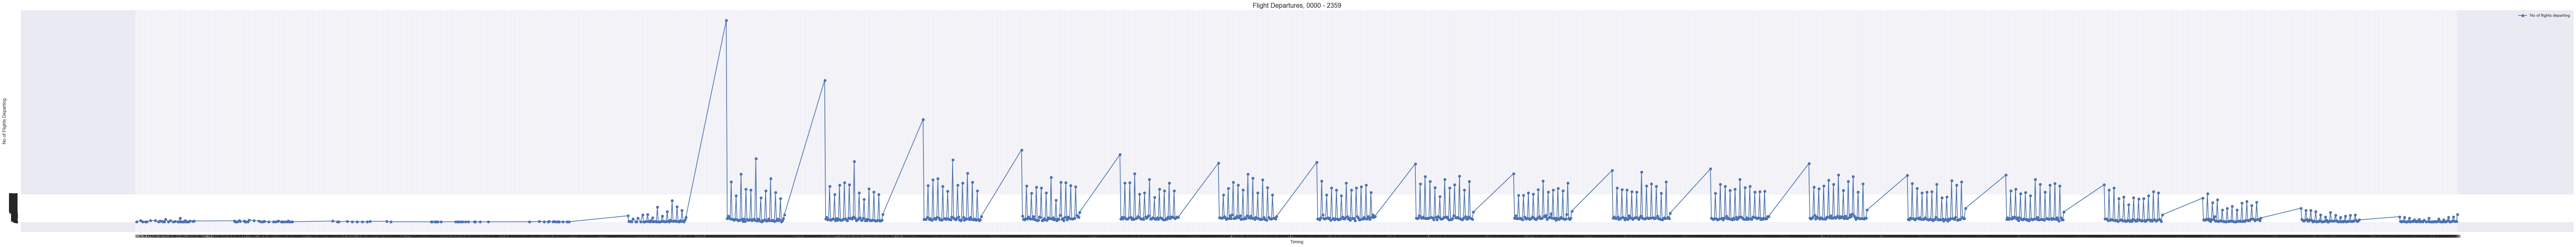

In [22]:
dep_df.head()
dep_timing = dep_df.groupby("SCHEDULED_DEPARTURE")
dep_timing_count = dep_timing.size().reset_index(name = "No of flights departing" )
dep_timing_count.head()

DIMS = (100,10)
sns.set()

fig = plt.figure(figsize = DIMS)
ax1 = fig.add_subplot(111)

ax1.set_title("Flight Departures, 0000 - 2359", fontsize = 16)
dep_timing_count.plot(kind = "line", 
                  x = 'SCHEDULED_DEPARTURE', 
                  y = 'No of flights departing', 
                  ax = ax1, 
                  marker = 'o'
)
plt.xticks(np.arange(0,2359))
plt.xlabel("Timing")

plt.yticks(np.arange(1,2815))
plt.ylabel("No of Flights Departing")
plt.show()

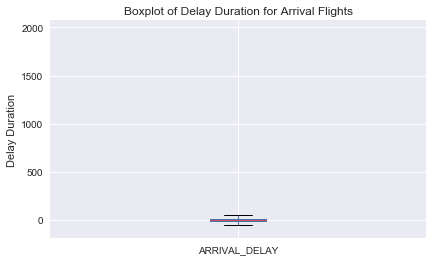

In [23]:
# BOXPPLOT TO SHOW Arrival Delay ATTRIBUTE DISTRIBUTION
fig, ax1 = plt.subplots()

arr_df["ARRIVAL_DELAY"].plot(kind = "box", ax = ax1)
ax1.set_ylabel("Delay Duration")
ax1.set_title("Boxplot of Delay Duration for Arrival Flights")
plt.show()

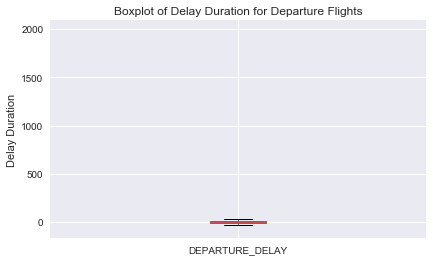

In [24]:
# Visualising the Number of Departure Delays in Boxplot
fig, ax2 = plt.subplots()
dep_df["DEPARTURE_DELAY"].plot(kind = "box", ax = ax2)
ax2.set_ylabel("Delay Duration")
ax2.set_title("Boxplot of Delay Duration for Departure Flights")
plt.show()

NotImplementedError: > 1 ndim Categorical are not supported at this time

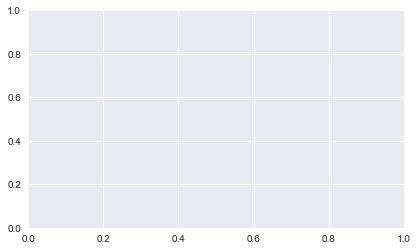

In [25]:
# Plot scatter plot for arr_df

fig, ax1 = plt.subplots()


arr_df_num = pd.DataFrame(arr_df.SCHEDULED_ARRIVAL)
arr_df_num = pd.CategoricalIndex(pd.Categorical(arr_df)) 

arr_df_num.plot(
    kind='scatter', ax=ax1,
    title='Scatterplot of Flight Delays',
    x='SCHEDULED_ARRIVAL', y='ARRIVAL_DELAY',
    figsize=(7, 7),)
ax1.set_ylabel("ARRIVAL_DELAY")
plt.show()


In [ ]:
# Plot scatter plot for dep_df

fig, ax1 = plt.subplots()
dep_df.plot(
    kind='scatter', ax=ax1,
    title='Scatterplot of Flight Delays',
    x='SCHEDULED_DEPARTURE', y='DEPARTURE_DELAY',
    figsize=(7, 7),)
ax1.set_ylabel("ARRIVAL_DELAY")
plt.show()


In [ ]:
#analyse missing pattern - matplotlib 
#Removing Outliers for Arrival Delay

quartile_1 = np.percentile(arr_df["ARRIVAL_DELAY"],25) #cannot run the whole sample
quartile_3 = np.percentile(arr_df["ARRIVAL_DELAY"], 75)
print(quartile_1)
print(quartile_3)

iqr = quartile_3 - quartile_1
print(iqr)

lower_bound = quartile_1 - 1.5*iqr
upper_bound = quartile_3 + 1.5*iqr

arr_df[(arr_df['ARRIVAL_DELAY'] < lower_bound) | (arr_df['ARRIVAL_DELAY'] > upper_bound)].sort_values(['ARRIVAL_DELAY'])

In [ ]:
#analyse missing pattern - matplotlib 
#Removing Outliers for Departure Delay

quartile_1 = np.percentile(dep_df["DEPARTURE_DELAY"],25) #cannot run the whole sample
quartile_3 = np.percentile(dep_df["DEPARTURE_DELAY"], 75)
print(quartile_1)
print(quartile_3)

iqr = quartile_3 - quartile_1
print(iqr)

lower_bound = quartile_1 - 1.5*iqr
upper_bound = quartile_3 + 1.5*iqr

dep_df[(dep_df['DEPARTURE_DELAY'] < lower_bound) | (dep_df['DEPARTURE_DELAY'] > upper_bound)].sort_values(['DEPARTURE_DELAY'])

In [ ]:
#Plotting the distribution of the flight count for delay for all airlines 
#Need to reformat the airline names
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
dep_df['DELAY_LEVEL'] = dep_df['DEPARTURE_DELAY'].apply(delay_type)

#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=dep_df)

# We replace the abbreviations by the full names of the companies and set the labels
labels = [airlines_df[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [ ]:
#Plotting the Delay Distribution Across All Airlines
#ERROR
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

In [ ]:
#Plotting Delay Distribution Using b Parameter 
#Error
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________

# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(airlines_df)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

Overall EDA explore:
- Delay according flight timing (for both departure and arrival)
- the performance across the airlines based on delay
- the delay distribution across all airports on the map

##### Finding Relationship between Origin Airport and Departure Delays

In [26]:
dep_df_groupby_origin = dep_df.groupby('ORIGIN_AIRPORT')
dep_df_origin_count = dep_df_groupby_origin.size().reset_index(name = "No. of flights at Origin Airport")

cond_dep_delay = dep_df["DELAY"] == "1"
dep_df_delay = dep_df[cond_dep_delay]

dep_df_delay_groupby_origin = dep_df_delay.groupby("ORIGIN_AIRPORT")
dep_delay_origin_count = dep_df_delay_groupby_origin.size().reset_index(name = "No. of Flights Delayed at Origin Airport")

by_origin = pd.merge(dep_df_origin_count, dep_delay_origin_count, how = "inner", on = "ORIGIN_AIRPORT")
by_origin["Proportion of Flights Delayed at Origin Airport"] = by_origin["No. of Flights Delayed at Origin Airport"] / by_origin["No. of flights at Origin Airport"]
by_origin = by_origin.sort_values(by = "Proportion of Flights Delayed at Origin Airport", ascending = False)
by_origin.head()

,ORIGIN_AIRPORT,No. of flights at Origin Airport,No. of Flights Delayed at Origin Airport,Proportion of Flights Delayed at Origin Airport
240,PPG,21,13,0.619048
133,GUM,69,42,0.608696
299,TTN,491,296,0.602851
155,ISP,770,460,0.597403
307,UST,31,18,0.580645


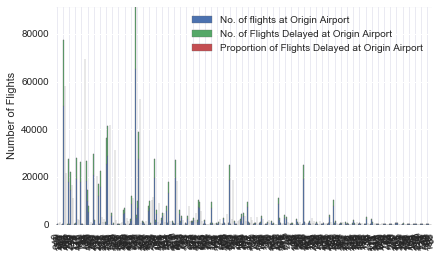

In [27]:
#Plotting stacked bars - number of flights and delays by origin airport

fig, ax1 = plt.subplots()
by_origin.plot(kind = "bar", 
               stacked = True, 
               ax = ax1

)

ax1.set_ylabel("Number of Flights")
plt.xticks(rotation=100)
plt.show()

In [51]:
# Findiing the mean delays per airport
# Basic Statistics for how origin airport impact delays

dep_df = dep_df.copy()
display(dep_df.head(3))

airport_mean_delays = pd.DataFrame(pd.Series(dep_df["ORIGIN_AIRPORT"].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

def get_stats(group): 
    return {"min": group.min(), "max":group.max(), "count": group.count(), "mean": group.mean()}

for carrier in abbr_companies.keys(): 
    dep_df_airline = dep_df[dep_df["AIRLINE"] == carrier]
    test = dep_df_airline["DEPARTURE_DELAY"].groupby(dep_df["ORIGIN_AIRPORT"]).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']
    
                                   

,DATE,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY
0,2015-01-01,AS,N407AS,ANC,SEA,5,2354.0,-11.0
1,2015-01-01,AA,N3KUAA,LAX,PBI,10,2.0,-8.0
2,2015-01-01,US,N171US,SFO,CLT,20,18.0,-2.0


In [34]:
origin_dict = dict()
for carrier in abbr_companies.keys(): 
    list_airport_origin = dep_df[dep_df["AIRLINE"] == carrier]
    list_airport_origin = list_airport_origin["ORIGIN_AIRPORT"].unique()
    origin_dict[carrier] = len(list_airport_origin)

origin_dict

{'UA': 78,
 'AA': 82,
 'US': 78,
 'F9': 63,
 'B6': 57,
 'OO': 181,
 'AS': 59,
 'NK': 33,
 'WN': 86,
 'DL': 147,
 'EV': 173,
 'HA': 17,
 'MQ': 123,
 'VX': 18}

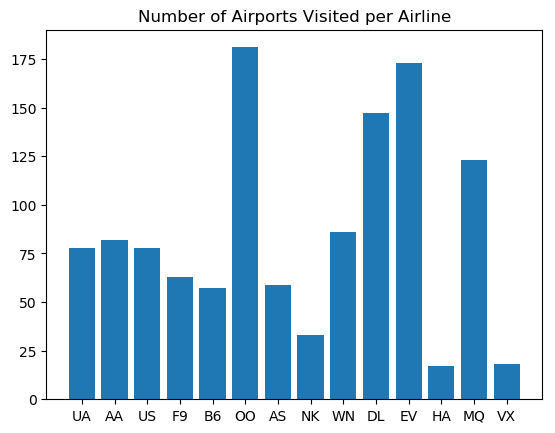

In [35]:
origin_dict
names = list(origin_dict.keys())
values = list(origin_dict.values())

plt.bar(range(len(origin_dict)), values, tick_label = names)
plt.title("Number of Airports Visited per Airline")
plt.show()

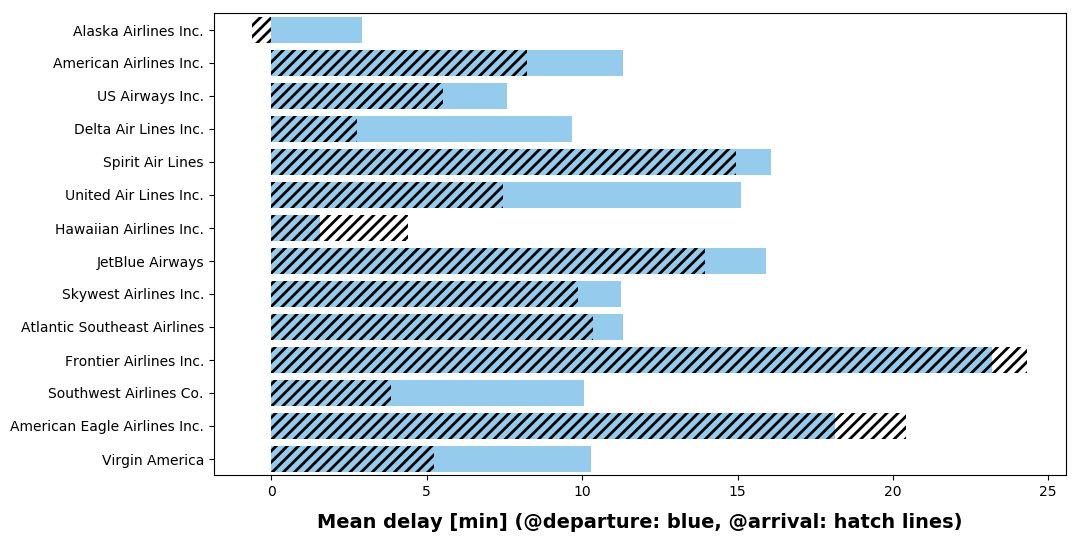

In [32]:
# Looking at how delays differ for arrival(landing) and departure (take-off)

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=dep_df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=arr_df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [55]:
airports_df.head()
identify_airport = airports_df.set_index('IATA_CODE')["CITY"].to_dict()
latitude_airport = airports_df.set_index('IATA_CODE')["LATITUDE"].to_dict()
longitude_airport = airports_df.set_index('IATA_CODE')["LONGITUDE"].to_dict()


#### Representing the travel routes colour-coded by flight frequency

In [64]:
# Cannot import basemap
mpl_toolkits.__path__.append('/usr/lib/pymodules/python2.7/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [73]:
# Showing number of flights with delays from origin to destination airport
#Code runs - Just need to import basemap from mpl_toolkits

def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig=plt.figure(figsize=(10,4))
    ax=fig.add_axes([0.,0.,1.,1.])
#m = Basemap(resolution='i',llcrnrlon=long_min, urcrnrlon=long_max,llcrnrlat=lat_min, urcrnrlat=lat_max,lat_0=0, lon_0=0)

dep_df_route = dep_df[dep_df['AIRLINE'] == carrier]
count_trajectories = dep_df_route.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).size()
count_trajectories.sort_values(inplace = True)
    
for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin], m.plot(nylon, nylat, 
    marker='o', markersize = 10, markeredgewidth = 1,
    color = 'seagreen', markeredgecolor='k')

for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
    lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
    if pd.isnull(nylat) or pd.isnull(nylon) or \
            pd.isnull(lonlat) or pd.isnull(lonlon): continue
    if s < 100:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b',
                             label = '< 100')
    elif s < 200:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r',
                             label = '100 <.< 200')
    else:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold',
                              label = '> 200')    
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('< 100', '100 <.< 200', '> 200')                
new_label = OrderedDict()

for key in key_order:
    if key not in by_label.keys(): 
        continue 
        new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), 
           loc = 'best', prop= {'size':8},
           title='flights per month', facecolor = 'palegreen', 
           shadow = True, frameon = True, framealpha = 1)    
#m.drawcoastlines()
#m.fillcontinents()
ax.set_title('{} flights'.format(abbr_companies[carrier]))

plt.show()

SyntaxError: invalid syntax (<ipython-input-73-04a642413e66>, line 24)

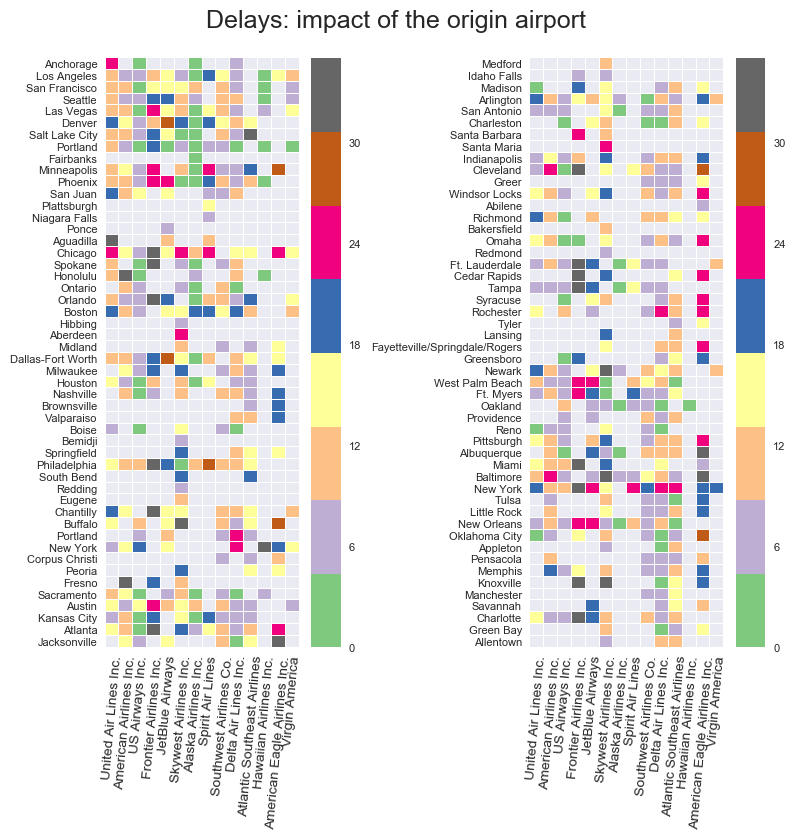

In [74]:
# Plotting heatmap of airport and airline delays

sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

In [76]:
# Determining if delays are due to route (Origin to destination airport)
# E.g for American Airlines --> CONVERT INTO FOR LOOP

carrier = 'AA'
dep_df_flight_route = dep_df[dep_df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]

# List of  routes and corresponding delays for each airline
trajet = dict()
for ind, col in dep_df_flight_route.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]

# Rranspose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

#print(liste_trajet)


[['ABQ-DFW', [14.0, -2.0, 14.0, 0.0, -1.0, -7.0, 52.0, -1.0, -2.0, -5.0, 1.0, -4.0, 0.0, -8.0, 14.0, -3.0, -2.0, 0.0, 0.0, -3.0, -3.0, -2.0, -7.0, 499.0, 0.0, 13.0, -5.0, 3.0, -5.0, -3.0, -9.0, -6.0, -4.0, -9.0, 53.0, -4.0, -4.0, 8.0, -7.0, -5.0, -7.0, 2.0, 10.0, -2.0, -9.0, 50.0, 17.0, -3.0, 35.0, 8.0, 9.0, 2.0, -1.0, -3.0, -6.0, -2.0, -9.0, 57.0, -3.0, -1.0, -5.0, -7.0, -10.0, -4.0, -4.0, -8.0, 7.0, -11.0, -3.0, 1.0, 2.0, -7.0, -6.0, -1.0, -9.0, 8.0, -2.0, -6.0, -2.0, -7.0, -6.0, 42.0, -6.0, -8.0, -6.0, -10.0, -8.0, -3.0, -8.0, -12.0, -6.0, -1.0, -4.0, -6.0, -21.0, -3.0, -7.0, -9.0, 3.0, -5.0, -6.0, -12.0, -16.0, -7.0, -3.0, -1.0, -1.0, -12.0, 25.0, -9.0, -13.0, 1.0, 136.0, -3.0, -3.0, -6.0, -8.0, 0.0, -3.0, -5.0, -7.0, 0.0, -13.0, 136.0, 19.0, 181.0, 14.0, 5.0, 0.0, -6.0, 6.0, 25.0, -3.0, -7.0, -5.0, -8.0, -7.0, -12.0, -9.0, -3.0, -7.0, -4.0, 78.0, -3.0, -11.0, -6.0, 83.0, -6.0, 129.0, 2.0, -3.0, -9.0, -4.0, -6.0, -12.0, -3.0, -2.0, -9.0, -9.0, -10.0, -7.0, -10.0, -6.0, -11.0, -7.0,

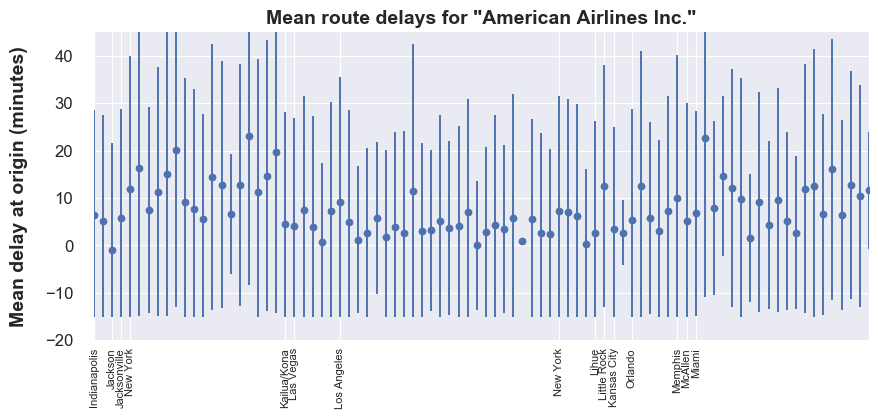

In [77]:
# Note liste_trajet only for Airline "AA"

mean_val = [] 
std_val = []
x_label = []

i = 0
for route, liste_retards in liste_trajet:
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    trajet2 = [min(90, s) for s in liste_retards] #include threshold to prevent over-weighted
    mean_val.append(scipy.mean(trajet2)) #calc mean
    std_val.append(scipy.std(trajet2)) #calc std var
    i += 1

# Plot the graph (Mean Route Delays)
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)

# Defining the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
    
# Setting the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

In [92]:
dep_df.columns
X = dep_df[["ORIGIN_AIRPORT"]] # Needs to be a dataframe
y = dep_df["DEPARTURE_DELAY"]

print(X.head(3))
print(y.head(3))

print(type(X))
print(type(y))

print(X.shape)
print(y.shape)

# Problem with model because origin airport is as catergory, need to covert it into an array

  ORIGIN_AIRPORT
0            ANC
1            LAX
2            SFO
0   -11.0
1    -8.0
2    -2.0
Name: DEPARTURE_DELAY, dtype: float64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(1009060, 1)
(1009060,)


In [93]:
dep_df.columns
X = dep_df[["SCHEDULED_DEPARTURE"]] # Needs to be a dataframe
y = dep_df["DEPARTURE_DELAY"]

print(X.head(3))
print(y.head(3))

print(type(X))
print(type(y))

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

   SCHEDULED_DEPARTURE
0                    5
1                   10
2                   20
0   -11.0
1    -8.0
2    -2.0
Name: DEPARTURE_DELAY, dtype: float64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(1009060, 1)
(1009060,)
(807248, 1)
(201812, 1)
(807248,)
(201812,)


In [94]:
dep_df['ORIGIN_AIRPORT_NO'] = pd.factorize(dep_df["ORIGIN_AIRPORT"], sort = True)[0]+1
dep_df.head()

# Assigning a number to each unique airline

,DATE,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,ORIGIN_AIRPORT_NO,DELAY
0,2015-01-01,AS,N407AS,ANC,SEA,5,2354.0,-11.0,16,0
1,2015-01-01,AA,N3KUAA,LAX,PBI,10,2.0,-8.0,172,0
2,2015-01-01,US,N171US,SFO,CLT,20,18.0,-2.0,273,0
3,2015-01-01,AA,N3HYAA,LAX,MIA,20,15.0,-5.0,172,0
4,2015-01-01,AS,N527AS,SEA,ANC,25,24.0,-1.0,272,0


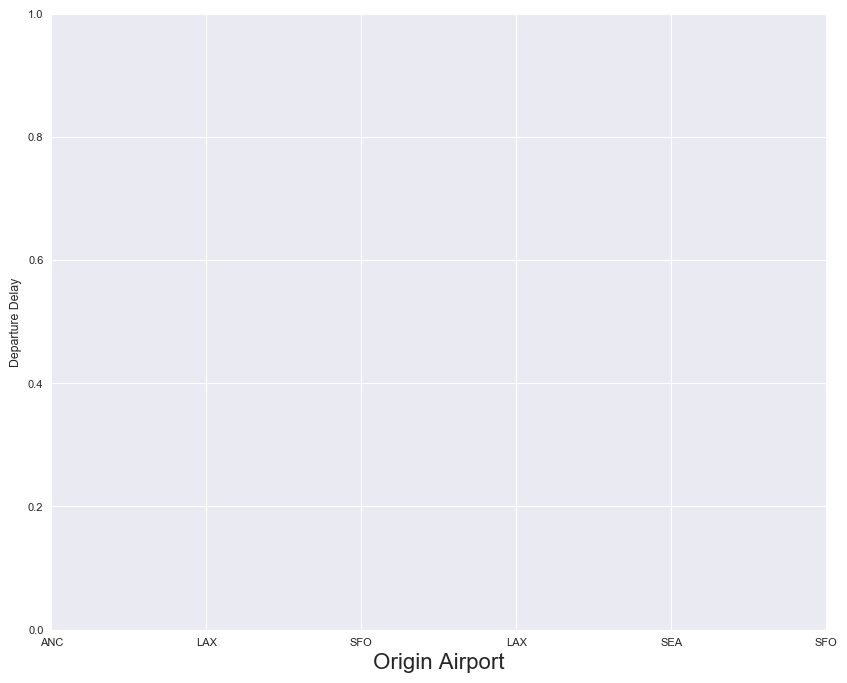

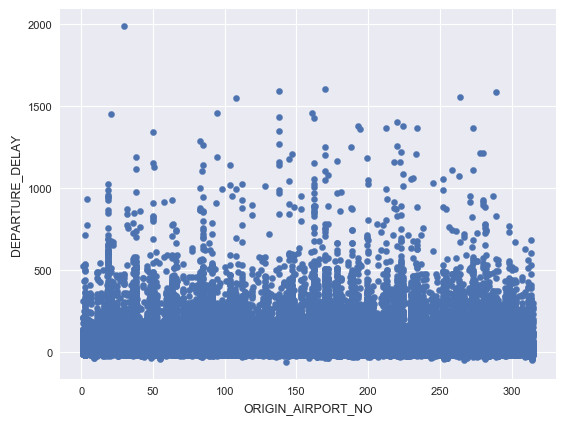

In [80]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

dep_df.plot(kind='scatter', 
        x='ORIGIN_AIRPORT_NO', 
        y='DEPARTURE_DELAY', 
        )

ax1.set_xlabel("Origin Airport", fontsize = 16)
ax1.set_ylabel("Departure Delay")
ax1.set_xticklabels(dep_df["ORIGIN_AIRPORT"])

plt.show()

# Scatter plot of Origin Airport and Departure Delay

In [95]:
# Setting the X 
features = ["ORIGIN_AIRPORT_NO", "DEPARTURE_DELAY"]
X = dep_df[features]
X.head()

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2, random_state = 0)

In [96]:
# Creating the KMeans model
from sklearn.cluster import KMeans
clustering_model = KMeans(n_clusters = 2, random_state = 0)
# setting clusters as 2
# How to determine number of clusters

trained_clustering_model = clustering_model.fit(X_train)
print(trained_clustering_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)


In [97]:
# Observing the clustering output for every observation
print(trained_clustering_model.labels_)

[1 1 1 ... 1 0 1]


In [98]:
X_results = X_train.copy()
X_results["Cluster"]= trained_clustering_model.labels_
X_results.head()

,ORIGIN_AIRPORT_NO,DEPARTURE_DELAY,Cluster
316866,202,-3.0,1
232744,178,-10.0,1
441391,281,-3.0,1
535617,19,-5.0,0
312590,162,33.0,1


How to test? X_test

In [99]:
# Displaying rows which fall under cluster 0
cond_0 = X_results["Cluster"] == 0
display(X_results[cond_0].head())

# Displaying rows which falls under cluster 1 
cond_1 = X_results["Cluster"] == 1
display(X_results[cond_1].head())

,ORIGIN_AIRPORT_NO,DEPARTURE_DELAY,Cluster
535617,19,-5.0,0
610956,19,-2.0,0
658985,13,0.0,0
811456,98,-8.0,0
1043693,38,-5.0,0


,ORIGIN_AIRPORT_NO,DEPARTURE_DELAY,Cluster
316866,202,-3.0,1
232744,178,-10.0,1
441391,281,-3.0,1
312590,162,33.0,1
939547,193,231.0,1


Obtaining coordinates of centroids

In [100]:
print(trained_clustering_model.cluster_centers_)

trained_clustering_model.cluster_centers_[0]
trained_clustering_model.cluster_centers_[1]

centroids_df_cols = ["ORIGIN_AIRPORT_NO", "DEPARTURE_DELAY"]
centroids_df = pd.DataFrame(
    trained_clustering_model.cluster_centers_, 
    columns = centroids_df_cols
)

centroids_df['label'] = centroids_df.index
centroids_df

[[ 75.13190684  11.45783512]
 [225.08302043  11.2688103 ]]


,ORIGIN_AIRPORT_NO,DEPARTURE_DELAY,label
0,75.131907,11.457835,0
1,225.083020,11.268810,1


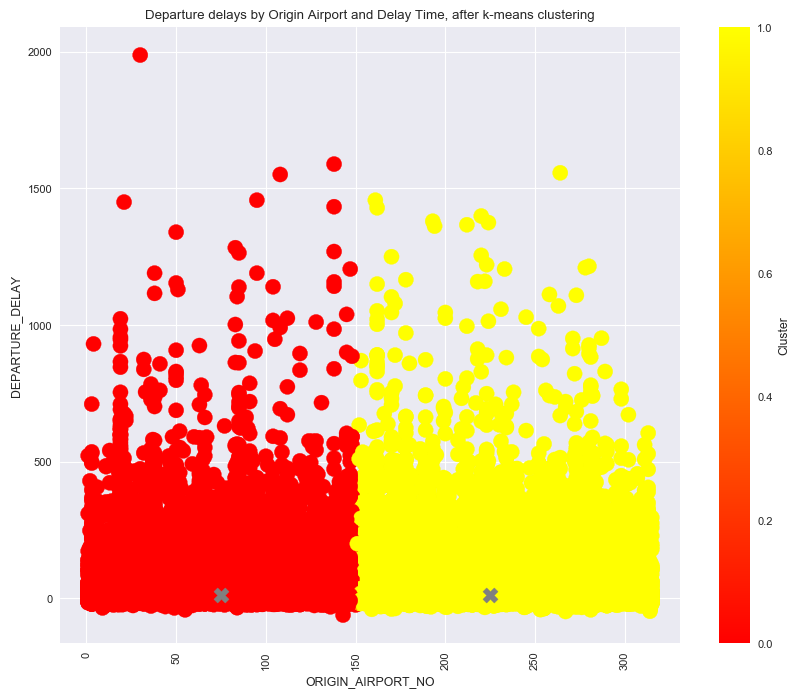

In [101]:
# Visualising 
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(111)

X_results.plot(
    kind = "scatter", ax = ax1, 
    x = "ORIGIN_AIRPORT_NO", y = 'DEPARTURE_DELAY', 
    s = 120, colormap = "autumn", c = "Cluster"
)

centroids_df.plot(
    kind = 'scatter', ax = ax1, 
    x = "ORIGIN_AIRPORT_NO", y = 'DEPARTURE_DELAY', 
    s = 120, marker = "X", color = 'gray'
)

ax1.set_title("Departure delays by Origin Airport and Delay Time, after k-means clustering")
plt.xticks(rotation = 90)
plt.show()

In [102]:
# Predicting

X_pred = pd.DataFrame([{'ORIGIN_AIRPORT': 75.13,
                        'DEPARTURE_DELAY': 11.46}])
X_pred

,DEPARTURE_DELAY,ORIGIN_AIRPORT
0,11.46,75.13


In [103]:
trained_clustering_model.predict(X_pred)

array([0])

#### Splitting into train_test_split

In [105]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:,.2f}'.format
sns.set()

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(807248, 2)
(201812, 2)
(807248,)
(201812,)


In [107]:
model = sm.OLS(y,X)
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.919e+35
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        01:29:04   Log-Likelihood:             2.9550e+07
No. Observations:             1009060   AIC:                        -5.910e+07
Df Residuals:                 1009058   BIC:                        -5.910e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
ORIGIN_AIRPORT_NO  1.984e-17   2.65e-1

In [108]:
dep_df["Predicted_delay"] = trained_model.fittedvalues
dep_df.head()

,DATE,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,ORIGIN_AIRPORT_NO,DELAY,Predicted_delay
0,2015-01-01,AS,N407AS,ANC,SEA,5,"2,354.00",-11.00,16,0,-11.00
1,2015-01-01,AA,N3KUAA,LAX,PBI,10,2.00,-8.00,172,0,-8.00
2,2015-01-01,US,N171US,SFO,CLT,20,18.00,-2.00,273,0,-2.00
3,2015-01-01,AA,N3HYAA,LAX,MIA,20,15.00,-5.00,172,0,-5.00
4,2015-01-01,AS,N527AS,SEA,ANC,25,24.00,-1.00,272,0,-1.00


In [120]:
results = model.fit()
y_pred = results.predict(X_test)

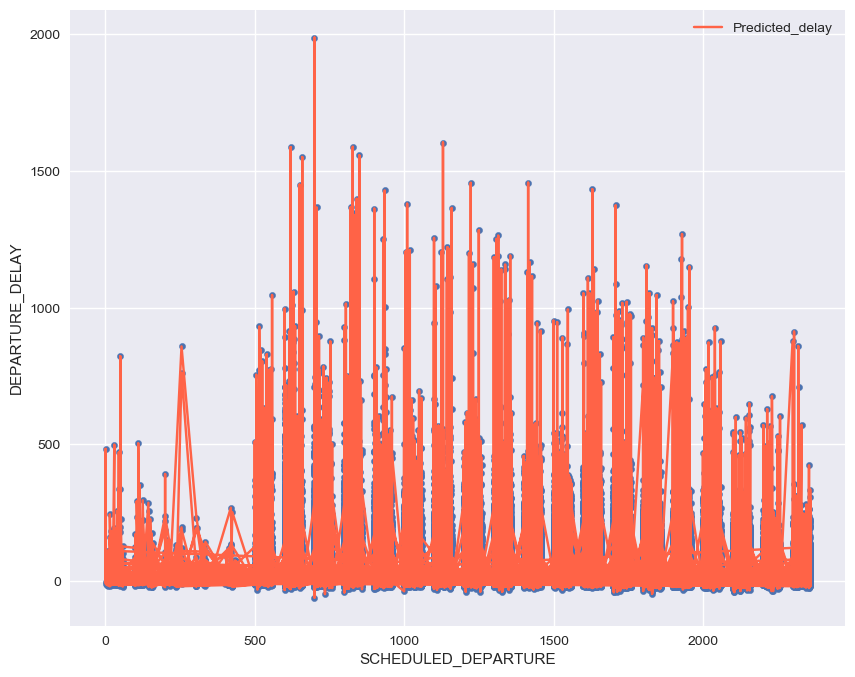

In [109]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
dep_df.plot(kind='scatter', 
        x='SCHEDULED_DEPARTURE', 
        y='DEPARTURE_DELAY', 
        ax=ax1)

# Plot the fitted line here
# Additional Plotting to show the model
dep_df.plot(kind="line", 
        x="SCHEDULED_DEPARTURE", 
        y="Predicted_delay", # line plot based on model
        ax=ax1, 
        color="tomato")


In [126]:
print(y_pred.dtype)
print(y_test.dtype)
from sklearn.metrics import confusion_matrix

# Displaying Confusion matrix

cm = confusion_matrix(y_test, y_pred) 
display(cm)

# Mixture of multiclass and continuous targets

float64
float64


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

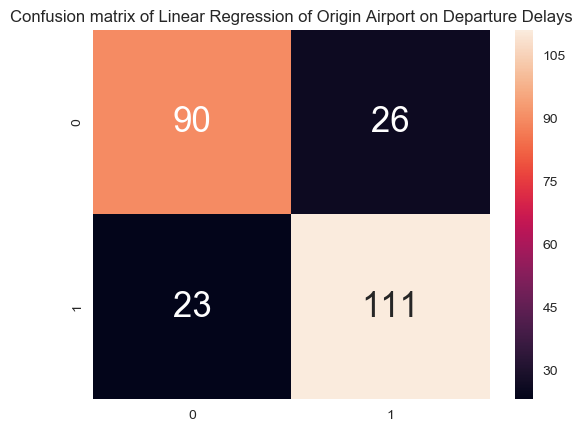

In [128]:
#Update cm after running cell above
cm = ([[ 90,  26],
       [ 23, 111]])

fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of Linear Regression of Origin Airport on Departure Delays")
plt.show()

#### Decision Tree

In [ ]:
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [ ]:
dep_df.head()

In [ ]:
# not complete yet - not sure what variables for further branching
dep_df.head()
dep_origin = dep_df.groupby("ORIGIN_AIRPORT").size().reset_index( name = 'No of Flights')
display(dep_origin)

fig= plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
dep_origin.plot(kind = "bar", x = "ORIGIN_AIRPORT", y = 'No of Flights', title = "No of Flights by Origin Airport", ax = ax1)
ax1.set_ylabel("No of flights")
plt.show()

#### Geographical Area Covered by Airlines

In [ ]:
# Number of airports visited by each airline 
#airline: no of airports 

dep_df_airline_origin = dep_df.groupby(["AIRLINE", "ORIGIN_AIRPORT"]).size().reset_index()
dep_df_airline_origin.head()

#origin_nb = dict()
#for carrier in dep_airlines.key(): 
    #list_origin_airport = dep_df[dep_df["AIRLINE"]== carrier]["ORIGIN_AIRPORT"].unique()
    #origin_dict[carrier] = len(list_origin_airport)


#### Predicting Flight Delays

In [129]:
# Reference from Kaggle
# Setting scope of departure date-time between 23rd Jan 2015
# Issue with date
dep_df_train = dep_df[dep_df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
dep_df_test  = de_df[dep_df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]

AttributeError: 'int' object has no attribute 'date'

In [130]:
# Insufficient Statistics
carrier = 'AA'
check_airports = dep_df[(dep_df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         dep_df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,count,max,mean,min
ORIGIN_AIRPORT,,,,
GUC,66.00,453.00,11.98,-24.00
SDF,56.00,95.00,8.20,-13.00
PNS,10.00,68.00,9.10,-11.00
LIT,9.00,74.00,12.56,-5.00
MTJ,9.00,51.00,16.56,-10.00


In [ ]:
# Extreme delays

### Classses of machine learning: 
- Classification - predict if there is a delay for the airline given a new observation that is unknown to the model
- anomaly detection - find out if a datapoint is weird or not - extreme delays

supervised - labels are the one guiding the model
unsupervised - no labels, trying to find patterns around the training set - clustering


Target variable (Y) - Delay vs No delay
Input variable (X / independent variables) - origin airport, scheduled time?
* Type of correlation
* distance from origin airport and destination airport * greater/ smaller delay - because the pilot can adjust to minimise the departure delay